# Example In Situ Sequencing Data
Here is a small example on how to run ISTDECO on an In Situ Sequencing dataset from [1]. (References are in the end of the notebook).

## Set path variables
The data and codebook can be downloaded from [2].

In [1]:
# Where to load the images and codebook from
data_path = '../../Data/ISTDECO_ISS_DATA' 

# Where to save .csv with results
csv_save_path = '../../Results/ISS/results.csv'

## Load the data

In [2]:
import numpy as np
from PIL import Image
from scipy.io import loadmat

rounds = 5
channels = 4 # A, C, G, T
tile_height, tile_width = 512, 512
ntile_y, ntile_x = 10, 18

data_shape = (rounds, channels, ntile_y*tile_height, ntile_x*tile_width)
image_data = np.zeros(data_shape, dtype='float32')

channels = ['A', 'C', 'G', 'T']
# Load images and tile
for r in range(rounds):
    for c in range(len(channels)):
        filepath = f'{data_path}/Round{r+1}/{channels[c]}.tif'
        im = np.array(Image.open(filepath), dtype='float32')
        image_data[r,c] = im   

# Load gene names and codebook
temp = loadmat(f'{data_path}/codebook.mat')
codebook = temp['codebook']
target_names = np.array([temp['target_names'][i][0][0] for i in range(len(temp['target_names']))])
codebook = codebook / codebook.sum(axis=(1,2), keepdims=True)

We need to set appropriate variables before we can run ISTDECO.

#### Notation
- $r$ Number of imaging rounds
- $c$ Number of channels
- $m$ Number of codes in codebook
- $h$ Image height
- $w$ Image width
- $\sigma_{psf}$ Standard deviation of the Gaussians describing the spatial shape of the spots
- $Y \in \mathbb{R}_+^{r\times c \times h \times w}$ Image data
- $D \in \mathbb{R}_+^{m \times r\times c}$ Codebook (Combinatorial labels)
- $b \in \mathbb{R}_+^{m \times r\times c}$ Background

In [3]:
r = 5
c = 4
m = codebook.shape[0]
h = 512
w = 512
sigma_psf = 1.
D = codebook
Y = image_data

# The images are already pre-processed
# with a baseline removal, hence we 
# put the baseline to an small-nonzero
# number. Mainly to avoid divisions by
# zero in the algorithm.
b = 1e-5

# Standard deviation of the point-spread-function
psf_std = 1.

# Number of iterations
niter = 75

# Suppression radius
local_max_radius = 1

# We want to use GPU
device = 'cuda'

# The images are too large to fit all on the GPU at once,
# hence we need to tile the images.
tiles = [(tiley,tilex) for tiley in range(ntile_y) for tilex in range(ntile_x)]

## Decode dataset

In [4]:
from tqdm import tqdm
import pandas as pd
from istdeco import ISTDeco

results = pd.DataFrame()
tau = np.percentile(image_data,99)

# Loop over the tiles
for iy, ix in tqdm(tiles):
    
    # Slice the image
    sy = slice(iy*tile_height, (iy+1)*tile_height)
    sx = slice(ix*tile_width, (ix+1)*tile_width)
    
    # Pick a tile
    tile = image_data[:,:, sy, sx] 
    
    # Create the model
    model = ISTDeco(tile,codebook, (psf_std,psf_std), b=b).to(device)
    
    # Run for few iterations and pick out 
    # deconvolved images
    X, Q, _ = model.run(niter=niter)
    
    # Pick out barcodes.
    # 99th percentile might seem like a strict choice, but recall 
    # that the images are very sparse, especially X. 
    code_id, y, x = np.where(np.logical_and(X>tau,Q>0.5))
        
    intensity = X[code_id, y, x]
    quality = Q[code_id, y, x]
                                 
    # Store in dataframe
    df = pd.DataFrame(data={
            'x': x.astype('float') + ix*tile_width, 
            'y': y.astype('float') + iy*tile_height,
            'target_id': code_id + 1, # Add a one here so id match with the benchmark
            'intensity': intensity, 
            'quality': quality,
            'target_name': target_names[code_id]
    })
                                 
    results = results.append(df)

results.to_csv(csv_save_path)

100%|██████████| 180/180 [05:23<00:00,  1.80s/it]


# Plot results
In the codebook we added nine additional "fake", or "non-targeted" codes. We can use these codes to assess the quality of the decoded barcodes.

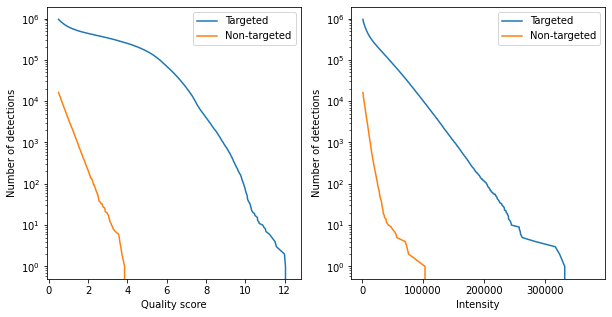

In [5]:
import matplotlib.pyplot as plt
# Name of nontargeted genes
non_targeted_names = [ f'blank-{i+1}' for i in range(9)]

# Load the raw decoding from the csv
results = pd.read_csv(csv_save_path)

# Split the dataframe into targeted and non targeted detections
ntargeted = results[results['target_name'].isin(non_targeted_names)]
targeted = results[~results['target_name'].isin(non_targeted_names)]

# Sort data by intensity and quality
ntargeted_quality = ntargeted.sort_values('quality',ascending=False)
ntargeted_intensity = ntargeted.sort_values('intensity',ascending=False)
targeted_quality = targeted.sort_values('quality',ascending=False)
targeted_intensity = targeted.sort_values('intensity',ascending=False)

# Plot curves
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.semilogy(targeted_quality['quality'].to_numpy(), \
             np.arange(0,targeted_quality.shape[0]), \
             label='Targeted')

plt.semilogy(ntargeted_quality['quality'].to_numpy(), \
             np.arange(0,ntargeted_quality.shape[0]), \
             label='Non-targeted')
plt.xlabel('Quality score')
plt.ylabel('Number of detections')
plt.legend()

plt.subplot(122)
plt.semilogy(targeted_intensity['intensity'].to_numpy(), \
             np.arange(0,targeted_quality.shape[0]), \
             label='Targeted')

plt.semilogy(ntargeted_intensity['intensity'].to_numpy(), \
             np.arange(0,ntargeted_quality.shape[0]), \
             label='Non-targeted')
plt.xlabel('Intensity')
plt.ylabel('Number of detections')
plt.legend()

From the above images we note that a quality threshold set to 0.6 seems to filter out many of the non-targeted detections while still keeping many the targeted detections. Let's use this threshold and check correlation with benchmark computed using pipeline in [1].

Text(0.5, 1.0, 'r = 0.9761286938922521')

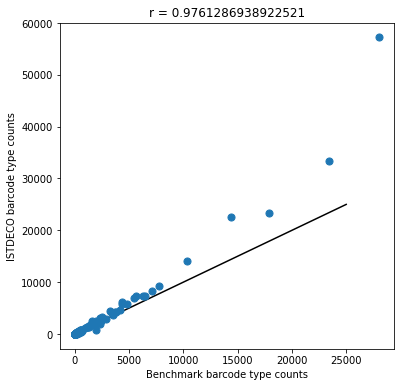

In [7]:
n_genes = 170
def count_targets(target_ids):
    return np.array([np.sum(target_ids == i+1) for i in range(n_genes)])
        
# Load benchmark genes
benchmark = pd.read_csv('benchmark/iss_benchmark.csv')
    
# remove barcodes near the border of the image
fov = [100,100,9215-200,5120-200]
results = results[ (results['x'] >= fov[0]) & (results['x'] <= fov[2])  & (results['y'] >= fov[1]) & (results['y'] <= fov[3])]
benchmark = benchmark[ (benchmark['x'] >= fov[0]) & (benchmark['x'] <= fov[2])  & (benchmark['y'] >= fov[1]) & (benchmark['y'] <= fov[3])]


# Filter detections such that less than n non targeted barcodes are detected
n = 10
threshold = ntargeted['quality'].nlargest(n).iloc[-1]
result_counts = count_targets(results[results['quality'] > threshold]['target_id'])

# Load the benchmark data and filter so that less than n non targeted barcodes are detected
threshold = benchmark[benchmark['is_non_targeted'] == 1]['quality'].nlargest(n).iloc[-1]
benchmark_counts = count_targets(benchmark[benchmark['quality'] > threshold]['target_id'])


# Plot the count of the different detected barcodes
tmp = np.vstack((result_counts, benchmark_counts)).T
r = np.corrcoef(tmp[:, 1], tmp[:, 0])[0, 1]
x = np.linspace(50, 25000)
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(tmp[:, 1], tmp[:, 0], 50, zorder=2)
ax.plot(x, x, '-k', zorder=1)

plt.xlabel('Benchmark barcode type counts')
plt.ylabel('ISTDECO barcode type counts')
plt.title(f'r = {r}')

# References
[1] *Qian, Xiaoyan, et al. "Probabilistic cell typing enables fine mapping of closely related cell types in situ." Nature methods 17.1 (2020): 101-106.*

[2] Axel Andersson, Ferran Diego, Fred A. Hamprecht, & Carolina Wählby. (2021). In Situ Sequencing data used in "ISTDECO: In Situ Transcriptomics Decoding by Deconvolution" [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4560687